# Environment setup

This notebook works with or without a Planetary Computer subscription key, but you will be given more permissive access to the data with a key. The Planetary Computer Hub is pre-configured to use your key.

In [2]:
import planetary_computer

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# planetary_computer.settings.set_subscription_key("add your key here")

# Open and explore the USGS GAP collection

[GAP/LANDFIRE](https://planetarycomputer-staging.microsoft.com/dataset/gap) is a national land cover dataset from the [USGS](https://www.usgs.gov/core-science-systems/science-analytics-and-synthesis/gap).
The Planetary Computer hosts the land cover dataset tiled into Cloud Optimized GeoTIFFs.


In [3]:
from pystac_client import Client

catalog = Client.open("https://planetarycomputer-staging.microsoft.com/api/stac/v1")
gap = catalog.get_child(id="gap")

The GAP dataset has four distinct regions:
- The continental United States (CONUS)
- Alaska
- Hawaii
- Puerto Rico

You can see those four bounding boxes in the collection spatial extent:

In [4]:
gap.extent.spatial.to_dict()

{'bbox': [[-127.9710481801793,
   22.797789263564383,
   -65.26634281147894,
   51.64692620669362],
  [-178.13166387448902,
   49.09079265233118,
   179.87849702345594,
   71.43382483774205],
  [-160.26640694607218,
   18.851824447510786,
   -154.66974350173518,
   22.295114188194738],
  [-67.9573345827195, 17.874066536543, -65.21836408976736, 18.5296513469496]]}

# Plotting land cover data

The Mount Whitney area of California is an interesting area for investiating land cover classifications.
The region includes developed areas, agriculture, forests, high alipine, and much more.
Let's take a look at the region in the land cover dataset.

In [5]:
bbox = [-118.35, 36.5, -118, 36.75]
search = catalog.search(collections="gap", bbox=bbox)
items = list(planetary_computer.sign(item) for item in search.get_items())
print(f"{len(items)} items found")

1 items found


In order to visualize the land cover data, we'll need to do a little work.
The land cover data contains its own color table, so we need to read this color table and create a colormap that can be used with matplotlib.
Also, because the source data is in a projected coordinate system, we'll need to transform our bounding box to that coordinate system for the merge.

In [12]:
from matplotlib.colors import ListedColormap
from pystac.extensions.projection import ProjectionExtension
import rasterio
from rasterio.crs import CRS
from rasterio.warp import transform_bounds

assert items
item = items[0]

with rasterio.open(item.assets["data"].href) as dataset:
    colormap = dataset.colormap(1)

keys = list(colormap.keys())
keys.sort()
assert keys == list(
    range(0, len(keys))
)  # We make sure that every possible input value has an associated color.
color_list = list([float(v) / float(255) for v in colormap[key]] for key in keys)
cmap = ListedColormap(color_list)

projection = ProjectionExtension.ext(item)
dst_crs = CRS.from_string(projection.wkt2)
src_crs = CRS.from_string("EPSG:4326")  # WGS84 geodetic
projected_bbox = transform_bounds(src_crs, dst_crs, *bbox)

Now we can plot the data, extracting the labels for the colors from the STAC item.

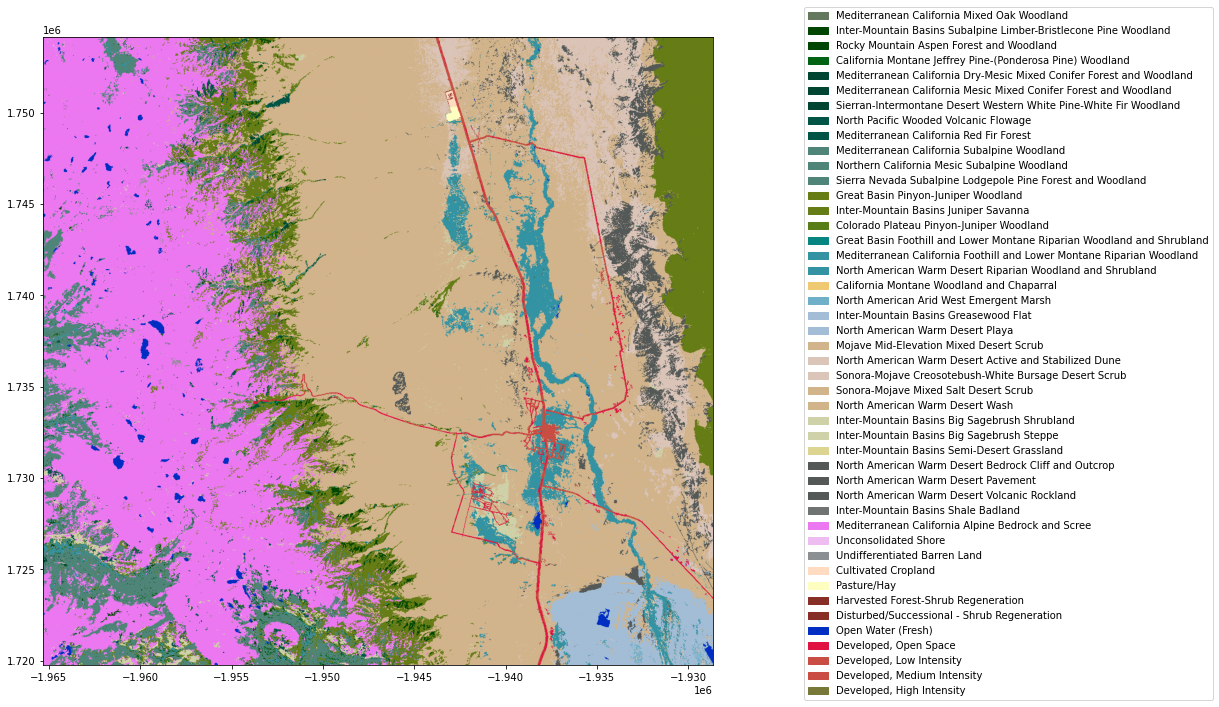

In [47]:
from matplotlib import pyplot
from matplotlib.patches import Patch
import numpy
from rasterio.plot import show
from rasterio.merge import merge
from pystac.extensions.label import LabelExtension

assets = [item.assets["data"].href for item in items]
data, transform = merge(datasets=assets, bounds=projected_bbox)
data = numpy.squeeze(data)
color_data = numpy.moveaxis(
    cmap(data), [0, 1, 2], [1, 2, 0]
)  # rasterio.show.show wants bands in (band, x, y) order

label = LabelExtension.ext(item)
patches = [
    Patch(color=cmap(v), label=label.label_classes[0].classes[v])
    for v in numpy.unique(data)
]

fig, ax = pyplot.subplots(figsize=(12, 12))
_ = show(color_data, ax=ax, transform=transform)
_ = fig.legend(handles=patches, loc=6, bbox_to_anchor=(1, 0.5))